### 1D Autoregressive Token prediction

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn

import jax.numpy as jnp
from jax import random



#### Data Preparation

##### Geometric Brownian Motion Simulator

$dS_t = \mu S_tdt + \sigma S_tdW_t \\$

$S_0$: Initial Stock price $\\$
$\mu$: Drift coefficient $\\$
$\sigma$: Volatility coefficient $\\$
$W_t$: Wiener Process (Brownian motion)

In [49]:
def gbm_simulator(key, S0, mu, sigma, T, dt):
    # Number of time steps
    N = int(T / dt)
    t = jnp.linspace(0, T, N)
    W = random.normal(key, (N,)) * jnp.sqrt(dt)
    
    # Wiener process
    W = jnp.cumsum(W)
    S = S0 * jnp.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    return S

# Parameters for the GBM
S0 = 100.0                  # Initial stock price
mu = 0.1                    # Drift coefficient
sigma = 0.2                 # Volatility coefficient
T = 5.0                     # Total time (year)
dt = 0.005                  # Time step

# Generate random key
key = random.PRNGKey(1)

# Simulate GBM
GBM_data = gbm_simulator(key, S0, mu, sigma, T, dt)

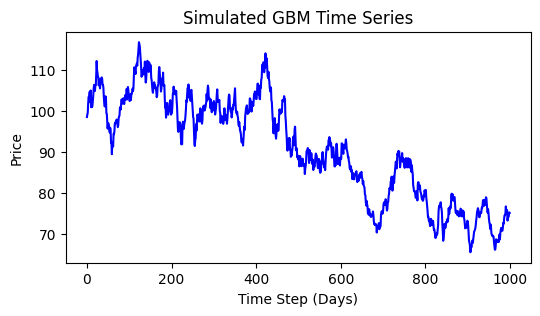

Mean Price: 90.83
Standard Deviation of Price: 12.69


In [50]:
# Plot the time series
plt.figure(figsize=(6, 3))
plt.plot(GBM_data, color ='blue')
plt.title('Simulated GBM Time Series')
plt.xlabel('Time Step (Days)')
plt.ylabel('Price')
plt.show()

# Calculate and print basic statistics
mean_price = jnp.mean(GBM_data)
std_dev_price = jnp.std(GBM_data)
print(f"Mean Price: {mean_price:.2f}")
print(f"Standard Deviation of Price: {std_dev_price:.2f}")

Discretizng data

In [91]:
data = np.array(GBM_data)
bin_start = 30
bin_stop = 180
num_bins = 30
bin_edges = np.linspace(bin_start, bin_stop, num_bins + 1)
# Tokenize the data
tokenized_data = np.digitize(GBM_data, bins=bin_edges, right=False) - 1
# Clip any prices below 30 to the first bin and above 170 to the last bin
tokenized_data = np.clip(tokenized_data, 0, num_bins - 1)
# Train / Test Split
train_data, temp_data = train_test_split(tokenized_data, train_size=0.7, shuffle=False)
val_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=False)

In [92]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return torch.tensor(sequences), torch.tensor(targets)

seq_length = 50  # Example sequence length

# [Input][Output], [1-50][51], [2-51][52], ... ,[750-799][800]
train_sequences, train_targets = create_sequences(train_data, seq_length)
val_sequences, val_targets = create_sequences(val_data, seq_length)
test_sequences, test_targets = create_sequences(test_data, seq_length)


In [93]:
# Create TensorDataset for each set
train_dataset = TensorDataset(train_sequences, train_targets)
val_dataset = TensorDataset(val_sequences, val_targets)
test_dataset = TensorDataset(test_sequences, test_targets)

# Create DataLoader for each set
batch_size = 32  # Example batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Check the loader
for batch_idx, (data, target) in enumerate(val_loader):
    print(batch_idx)
    print(data[3])
    print(target[3])


In [118]:
# Define the embedding layer
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Dense output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.embedding(x)  # Convert tokens to dense vectors
        #lstm_out, _ = self.lstm(x)  # Pass the embedded sequences through the LSTM
        #output = self.fc(lstm_out[:, -1, :])  # Output layer
        return x        # OUTPUT INSTEAD OF X



In [115]:
# Example model parameters
embedding_dim = 32              # Size of embedding vector
hidden_dim = 128                # Number of LSTM units
vocab_size = num_bins           # Number of unique Tokens
output_dim = vocab_size         # Ouput size is the number of unique Tokens again

In [119]:
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)

In [126]:
data_iter = iter(val_loader)

# Get the first batch
first_batch = next(data_iter)
val_1, target_1 = first_batch
print(val_1[0])
print(target_1[0])

tensor([ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11,
        12, 11, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])
tensor(11)
